# EDA showcase: USA-based flights information EDA

 # Navit Dori

The dataset I am using here is taken from Data Expo competition (2009). The dataset consists of flight arrival and departure details for all the commercial flights within the USA, in 2007. 

This notebook summerises EDA, model building and model assessment for the prediction of flight delays. 
In order to simplify presentation some repetitious code was exluded, as well as some straight forward EDA code.



Raw data consists of the following columns:

* 1 Year 2007
* 2 Month 1-12 
* 3 DayofMonth 1-31 
* 4 DayOfWeek 1 (Monday) - 7 (Sunday) 
* 5 CRSDepTime scheduled departure time (local, hhmm) 
* 6 CRSArrTime scheduled arrival time (local, hhmm) 
* 7 UniqueCarrier unique carrier code 
* 8 FlightNum flight number 
* 9 ActualElapsedTime in minutes 
* 10 ArrDelay arrival delay, in minutes  
* 11 Origin origin IATA airport code 
* 12 Dest destination IATA airport code 
* 13 Distance in miles 
* 14 Diverted 1 = yes, 0 = no  in our data no flight was difverted so I deleted this column

All descriptions are straight forward except ActualElaspedTime. I will attempt to interpret it below.

### EDA

#### Checking for constant columns, null values, negative values, outliers


1. The column Diverted is constant - all zeros - and therefore is removed from data. A constant column can not contribute information and will not improve predictions. The Year column is also constant - for the data is restricted to the year 2007. I use it to create a Datetime object of departure and arrival for each flight, and then discard it.
2. A simple command, df.isnull().any(), shows there are no null values in the raw data.
3. I checked the distribution of (numeric) values using commands like df.describe().
   For example, columns such as distance, Month, DayofMonth, DayofWeek should not have negative values (and they don't).
4. I plotted distribution/scatter plots of the columns and checked for outliers. I found one very distinct outlier in the ArrDelay and that row is removed from the data.
5. I calculated that there are 304 airports, with the same origin and destination list of airports. 

#### Creating Departure and Arrival Datetime Objects

CRSDepTime and CRSArrTime (scheduled departure and arrival time respectively) are given in an usual format: hhmm with no ':' in between. In addition, they are in local time and in 24-hour clocks.
My next step is to constract an aware datetime object that includes the correct date and time in order to enable comparison of times in different time zones. 

Interestingly, the date for arrivals is not given. One must infer arrivald date from the data. I checked and all flights withing USA airports are less then 12 hours (as long as they are under 24 hours this method applies). Therefore if arrival hour is smaller than departure hour, the flight has changed dates. It is iportant to make this comparrison when departure hour and arrival hour are in the same time zone.

Parsing the Datetime has two steps.
First I add time zone data to the previously given dataset. Two columns are added DepTZ, which is the departure airport time zone information, and ArrTZ, which is the arrival airport time zone information. 

Then I creat the aware datetime for departures and arrivals, taking into account flights that cross over into the the next day. I add another feature, DepTime_in_ArrTZ which is the aware departure time in the destination airport time zone. Ostensibly this feature is not needed after I check for flights that fly through midnight and change the date, however, I keep this feature in the dataframe, thinking it may come in handy later. 



##### Reading Raw Data and Adding Time Zone Information
In the following cell I upload the original csv file, 'data.csv'. 
1. A constant column, 'Diverted', whose values do not change, is removed.
2. Time zone data is merged into the original dataset using an independent IATA dataset and a function extract_TZ_data. For each row there are two merges: for departure airport of for arrival airport.
3. Date: there are no flights longer than 12 hours so if the arrival time is smaller than departure time it means we changed date for the planned CRS arrival time.
4. Then there are 5 new columns:
- DepTime: aware datetime object of departure time
- ArrTime: aware datetime object of arrival time
- DepTimeArrTZ: departure time in arrival airport timezone. This is useful for calculcating planned Elapsed Time
- PlannedElapsedTime: arrival time - departure time in the same (arrival) time zone
- ActualArrivalTime: PlannedElapsedTime + Delay

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from TimeParserFunctions import extract_TZ_data, format_time, get_airport_timezone, get_aware_datetime, get_awareDepArrTimes

numRows_to_download=10000

df = pd.read_csv('data.csv',nrows=numRows_to_download).drop(labels=['Diverted'], axis=1)  #read only first 10000 lines for illustration
airport_data_file = '..\\..\\AirportData\\airports-extended.dat' #airports-extended has TZ information
unq_org = df.Origin.unique() # in the big dataset this is equal to unq_Dest
#here I need to combine this with
unq_dest = df.Dest.unique()
unq_arp = np.concatenate((unq_org,unq_dest))
unq_arp = set(unq_arp)
airport_data = extract_TZ_data(unq_arp,airport_data_file) #airport_data contains TZ information for each airport 304 rows.

df = df.merge(airport_data.loc[:,['IATA','TZ Database']], # get Departure airport TZ
         how = 'left',
         left_on = 'Origin',
         right_on =  'IATA',
         suffixes = (None,'_Org')
        )
df = df.rename(columns={'TZ Database': 'DepTZ'}) #df is raw data + DepTZ information

df = df.merge(airport_data.loc[:,['IATA','TZ Database']],  #df is raw data + DepTZ+ ArrTZ information
         how = 'left',
         left_on = 'Dest',
         right_on =  'IATA',
         suffixes = (None,'_Dest')
        )

df = df.rename(columns={'TZ Database': 'ArrTZ'}) 
df = df.drop(columns=['IATA','IATA_Dest'],axis=1)


DepTime_col_name = 'DepTime'               #new column 
DepTimeArrTZ_col_name = 'DepTime_in_ArrTZ' #new column
ArrTime_col_name = 'ArrTime'               #new column  

#Creating the aware datetime features
for i in df.index:
    df = get_awareDepArrTimes(i,df,DepTime_col_name, DepTimeArrTZ_col_name, ArrTime_col_name)

In [2]:
df.columns

Index(['Year', 'Month', 'DayofMonth', 'DayofWeek', 'CRSDepTime', 'CRSArrTime',
       'UniqueCarrier', 'FlightNum', 'ActualElapsedTime', 'Origin', 'Dest',
       'Distance', 'ArrDelay', 'DepTZ', 'ArrTZ', 'DepTime', 'DepTime_in_ArrTZ',
       'ArrTime'],
      dtype='object')

#### Uploading Full Data with Preprocessed Time


- df14 sampled data
- df16 full data
The above code is given here to illustrate how I overcame the time zone problem.
In the following I upload a DataFrame where these features and other new features already exist. Later I will elaborate on the reasoning and the code leading to these new features.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
cols = ['Month', 'DayofMonth', 'DayofWeek', 'UniqueCarrier','FlightNum', 'Origin', 'Dest', 'Distance', 
        'DepTime','ArrTime','DepTimeUTC', 'ArrTimeUTC', 'DepTimeHrOnly', 'ArrTimeHrOnly', 
        'ArrDelay']

dtype_dict = {'Year' : 'uint16',  
             'Month': 'uint8', \
             'DayofMonth' : 'uint8', \
             'DayofWeek' : 'uint8', \
             'CRSDepTime' : 'uint16', \
             'CRSArrTime' : 'uint16', \
             'FlightTime' : 'uint16', \
             'ActualElapsedTime' : 'uint16', \
             'Distance' : 'uint16', \
             'ArrDelay' : 'int16'}
 
df16 = pd.read_csv('..\\AirportData2\\df16_csv', usecols=cols, dtype = dtype_dict ) 

#### Basic EDA

##### A Histogram of the Delays (the Target)

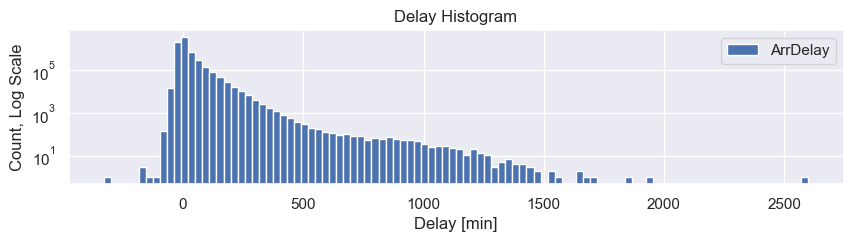

In [16]:
sns.set_theme()
df16[df16['ArrDelay']!=0].plot.hist(column=['ArrDelay'], bins=100, figsize=(10,2),logy=True,range=[-330,2600])
plt.ylabel('Count, Log Scale')
plt.xlabel('Delay [min]')
plt.title('Delay Histogram')
plt.show()


In [6]:
len(df16[df16.ArrDelay==0])/len(df16)

0.027952845303168754

3% of delays are exactly zero

52% smaller or equal to zero

In [409]:
len(df16[df16.ArrDelay<=0])/len(df16)

0.5253170733584704

imbalance: 93% of has less than 1 hour delay


In [388]:
df16.ArrDelay.describe()

count    7.275288e+06
mean     1.019218e+01
std      3.930774e+01
min     -3.120000e+02
25%     -9.000000e+00
50%      0.000000e+00
75%      1.400000e+01
max      2.598000e+03
Name: ArrDelay, dtype: float64

In [4]:
df16.columns

Index(['Month', 'DayofMonth', 'DayofWeek', 'UniqueCarrier', 'FlightNum',
       'Origin', 'Dest', 'Distance', 'ArrDelay', 'DepTime', 'ArrTime',
       'DepTimeUTC', 'ArrTimeUTC', 'DepTimeHrOnly', 'ArrTimeHrOnly'],
      dtype='object')

##### Delay by Month

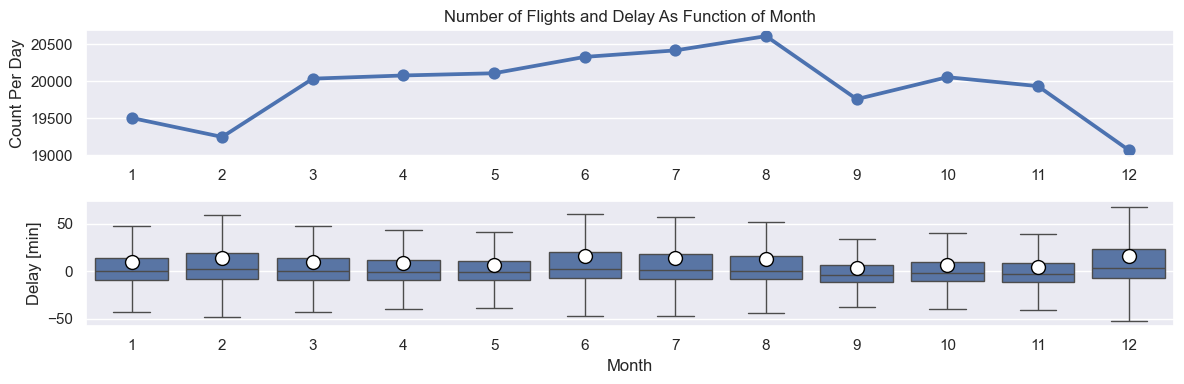

In [15]:

MonthVolume = df16.groupby('Month').size()
dayspermonth = [31,28,31,30,31,30,31,31,30,31,30,31]
f, axs = plt.subplots(2, 1, figsize=(12, 4) )
#ax=sns.pointplot(x=range(1,13),y=MonthVolume,ax=axs[0])
ax=sns.pointplot(x=range(1,13),y=round( MonthVolume.divide(dayspermonth) ),ax=axs[0])
ax.set(ylabel='Count Per Day',title='Number of Flights and Delay As Function of Month')
ax=sns.boxplot(x="Month", y="ArrDelay", data=df16, 
               showmeans=True,
               meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"},
               showfliers=False,ax=axs[1])
ax.set(ylabel='Delay [min]',xlabel='Month')
f.tight_layout()
plt.show()


Upper panel: number of flights per Day, plotted against month. Number of flights is roughly the same, 
but February and December have slightly less flights per day and Jun-August slightly more flights per day.

Lower panel: box and whisker plot of distribution of delays per month. Months June, July, August and December have higher 
mean (white circle) and higher medians (central black line).
Interquantile range of these months, and to a slightly less degree, February, is also considerably larger then the rest of 
the year. 
Conclusion: a mixed effect
The longer delays in the summer months may be due to larger number of flights.
I could check this by calculating the correlation between delays and number of flights per day between May and September.
The longe delays in February in December may be due to weather. I could check this by adding weather data of these months.

Another possible cause for the longer delay could be having concentrated busy days, which is what I suspect happens
in December - days with lots of flights and later days with less to no flights (Christmas).
That could be checked by looking at the distribution of flights during December.

##### Day of Month

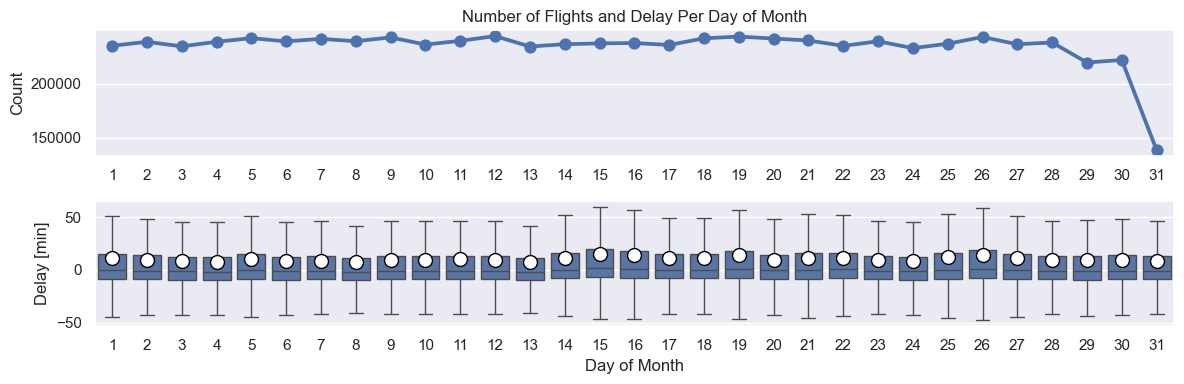

In [113]:
Volume = df16.groupby('DayofMonth').size()
f, axs = plt.subplots(2, 1, figsize=(12, 4) )
ax0=sns.pointplot(x=df16.DayofMonth.unique(),y=Volume,ax=axs[0])
ax0.set(ylabel='Count',title='Number of Flights and Delay Per Day of Month')
ax1=sns.boxplot(x="DayofMonth", y="ArrDelay", data=df16, 
               showmeans=True,
               meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"},
               showfliers=False,ax=axs[1])
ax1.set(xlabel='Day of Month',ylabel='Delay [min]')
f.tight_layout()
plt.show()


Upper panel: the number of flights as function of the day of month, averaged over all months.
Lower panel: the distribution of delays as function of day of month.
    
There isn't much difference in number of flights as function of the day of the month. The pronounced depression 
in days 28-30 is due to the fact that there are less such dates.

There is a slight elevation of average delay on some dates: 15, 16, 19, 26.
The reason for this is unclear and could be only due to noise.
I could check this by plotting the daily delay of some dates during the year and see if there is much fluctuations. 

##### Delay per weekday

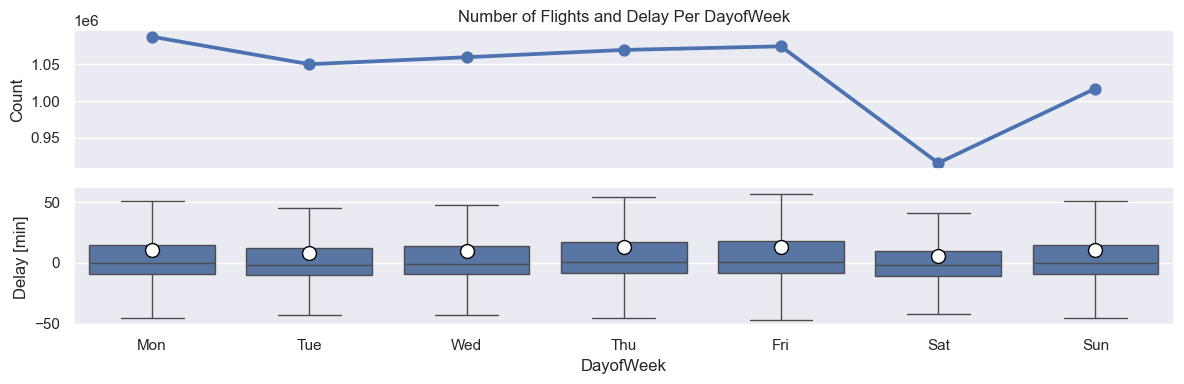

In [114]:
column = 'DayofWeek'
Volume = df16.groupby(column).size()
f, axs = plt.subplots(2, 1, figsize=(12, 4) )
ax1=sns.pointplot(x=df16.loc[:,column].unique(),y=Volume,ax=axs[0])
ax1.set(ylabel='Count',title='Number of Flights and Delay Per '+str(column),xticklabels=[])
ax1=sns.boxplot(x="DayofWeek", y="ArrDelay", data=df16, 
               showmeans=True,
               meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"},
               showfliers=False,ax=axs[1])
ax1.set(xlabel='Day of Week',ylabel='Delay [min]')
ax1.set(xlabel=str(column),ylabel='Delay [min]',xticks=['1','2','3','4','5','6','7'],
        xticklabels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
f.tight_layout()
plt.show()

Upper panel: number of flights as function of day of week. Saturday and Sunday have slightly less flights then the rest of the week.

Lower panel: average delay as function of day of week. Saturday has slihtly less delays compared to teh rest of he week, but Sunday does not follow this trend, and in spite of the relatively low number of flights the dealys are similar to weekdays.

In addition there are slightly longer delays on Thurdays and Fridays, however, we can not attribute this to being busier days becaus Mondays have the most fligths yet the delays are slightly shorter than Thursdays and Fridays



##### Delay by Hour of Day

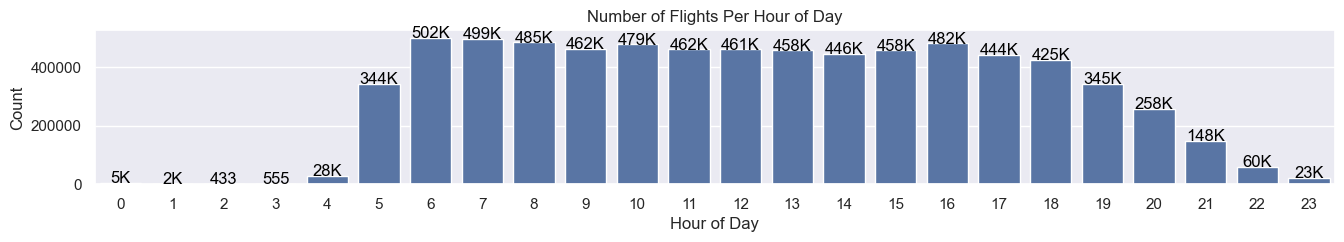

In [118]:
f, axs = plt.subplots(1, 1, figsize=(16, 2) )

groupedValues = df16.groupby('DepTimeHrOnly').size().reset_index()
groupedValues = groupedValues.rename(columns={0: 'NumFlights'})
rank = groupedValues['NumFlights'].argsort()
ax = sns.barplot(x='DepTimeHrOnly', y='NumFlights', 
                 data=groupedValues)
ax.set(xlabel='Hour of Day',ylabel='Count',title='Number of Flights Per Hour of Day') 
for index, row in groupedValues.iterrows():
    if row.NumFlights<1000:
        ax.text(row.DepTimeHrOnly, row.NumFlights, row.NumFlights,
            color='black', ha='center')
    else:
        ax.text(row.DepTimeHrOnly, row.NumFlights, str( round(row.NumFlights/1000))+'K',
            color='black', ha='center')
        
#ax1.set(xlabel=str(column),ylabel='Delay [min]',xticks=['1','2','3','4','5','6','7'],
#        xticklabels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])


A graph of the number of flights as function of the hour of day shows there is significant more flights during day hours - 
5am to 9pm, with 3-5 thousands of flights per hour (over the whole dataset). Between 2-3am the number of flights reduces to the hundreds.  
Here the number of flights is calculated by the number of deaprtures.

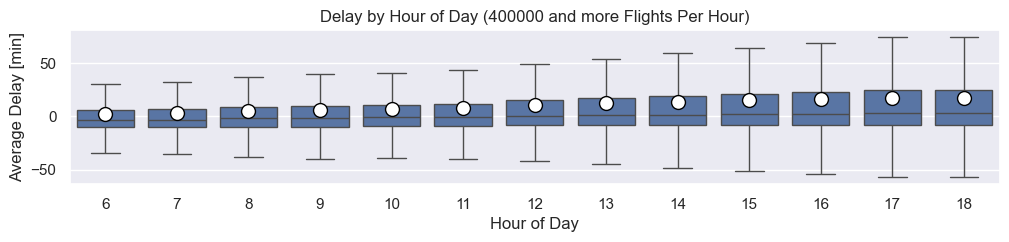

In [119]:
starthour=6
endhour=19
dfhours=pd.DataFrame()
nsamples=400000
groups = df16.groupby('DepTimeHrOnly')
for h in range(starthour,endhour):
    agroup = groups.get_group(h).sample(nsamples,random_state=0,replace=True)
    dfhours = pd.concat(
        [dfhours,pd.DataFrame(
            {'Delay':pd.Series(agroup.ArrDelay,index=agroup.index), 
             'Hours':pd.Series([h]*len(agroup),index=agroup.index)})] )

sns.set(rc={'figure.figsize':(12,2)})
ax=sns.boxplot(x="Hours", y="Delay", data=dfhours, showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
            showfliers=False)

ax.set(xlabel='Hour of Day',ylabel='Average Delay [min]',title='Delay by Hour of Day (400000 and more Flights Per Hour)')
plt.show()


Between 6am and 6pm, which are the busiest hours of the day, there is a marked increase of delays as the day progresses.
I suspect that this is a "traffic jam" effect, where delayed flights cause delay in later flights. 
I could check this by looking at the average delay per hour of day at specific airports and compare days that started with dealys to days that started without delays.

##### Delay by Arrival hour

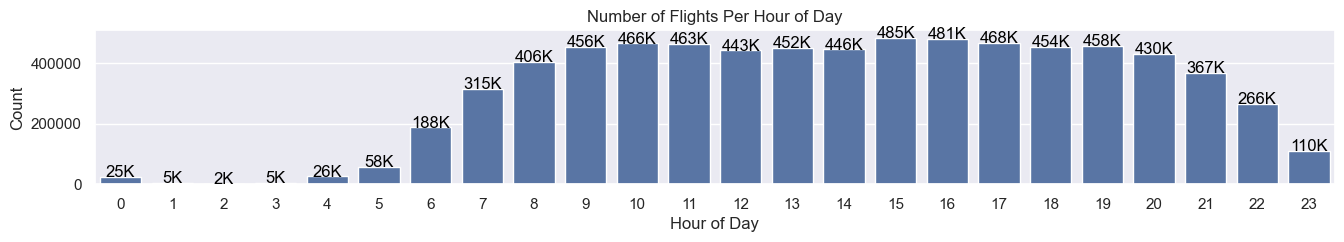

In [158]:
f, axs = plt.subplots(1, 1, figsize=(16, 2) )
groupedValues = df16.groupby('ArrTimeHrOnly').size().reset_index()
groupedValues = groupedValues.rename(columns={0: 'NumFlights'})
rank = groupedValues['NumFlights'].argsort()
ax = sns.barplot(x='ArrTimeHrOnly', y='NumFlights', 
                 data=groupedValues)
ax.set(xlabel='Hour of Day',ylabel='Count',title='Number of Flights Per Hour of Day') 
for index, row in groupedValues.iterrows():
    if row.NumFlights<1000:
        ax.text(row.ArrTimeHrOnly, row.NumFlights, row.NumFlights,
            color='black', ha='center')
    else:
        ax.text(row.ArrTimeHrOnly, row.NumFlights, str( round(row.NumFlights/1000))+'K',
            color='black', ha='center')

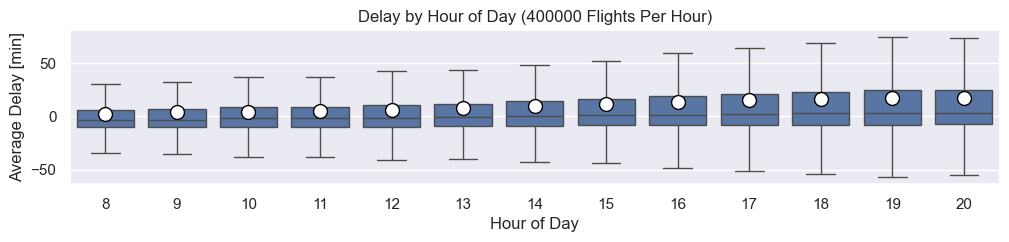

In [159]:
starthour=8
endhour=21
dfhours=pd.DataFrame()
nsamples=400000
groups = df16.groupby('ArrTimeHrOnly')
for h in range(starthour,endhour):
    agroup = groups.get_group(h).sample(nsamples,random_state=0,replace=True)
    dfhours = pd.concat(
        [dfhours,pd.DataFrame(
            {'Delay':pd.Series(agroup.ArrDelay,index=agroup.index), 
             'Hours':pd.Series([h]*len(agroup),index=agroup.index)})] )

sns.set(rc={'figure.figsize':(12,2)})
ax=sns.boxplot(x="Hours", y="Delay", data=dfhours, showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
            showfliers=False)

ax.set(xlabel='Hour of Day',ylabel='Average Delay [min]',title='Delay by Hour of Day (400000 Flights Per Hour)')
plt.show()


The graf of delays as function of arrivals is very similar to the graph of delays as function of departures, 
except that the "busy" hours are "pushed" two hours later, to 8am and 8pm. 

##### FlightNum and Unique Carrier

If we take four indicators: flight number, unique carrier, origin and destination we can find flights that repeat daily/weekly.
We could suspect that a recurrent flight has recurrent delays, and that delays of past daily/weekly flights could
indicate delays in future such daily/weekly flights.

In [5]:
df16['FlightCount'] = df16.groupby(['UniqueCarrier','FlightNum','Origin','Dest']).transform('size')
df16['FlightMeanDelay'] = df16.groupby(['UniqueCarrier','FlightNum','Origin','Dest'])['ArrDelay'].transform('mean')
df16.FlightMeanDelay = df16.FlightMeanDelay.round()
FlightDelay10 = df16.groupby(['UniqueCarrier','FlightNum','Origin','Dest'])['ArrDelay'].rolling(10 , closed='left').mean() #249317 NaN
FlightDelay10 = pd.DataFrame(FlightDelay10)
FlightDelay10.reset_index(inplace=True, level = ['UniqueCarrier','FlightNum','Origin','Dest'])
FlightDelay10.drop(columns=['UniqueCarrier','FlightNum','Origin','Dest'],axis=1,inplace=True)
FlightDelay10.rename(columns={'ArrDelay':'Delayby10Flights'},inplace=True)
df16 = df16.merge( FlightDelay10 , copy=False, left_index=True, right_index=True )

49345 daily (365) flights


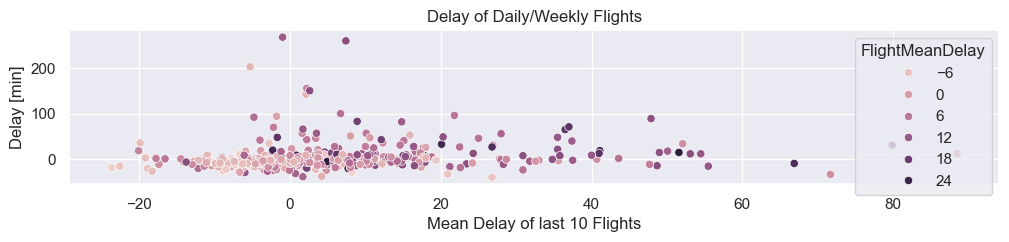

In [77]:
sns.set(rc={'figure.figsize':(12,2)})
vec = df16[ (df16.FlightCount==365) & (df16.Delayby10Flights.notna()==True) ].Delayby10Flights.index
ax=sns.scatterplot(data=df16.loc[vec,:].sample(frac=0.01), x="Delayby10Flights",y="ArrDelay", hue = 'FlightMeanDelay')
ax.set(xlabel='Mean Delay of last 10 Flights',ylabel='Delay [min]',title='Delay of Daily/Weekly Flights')
plt.show()



Roughly 2,034,351 out of 7,275,288 are daily flights ( above 300 repetitions within the year).
Data of only 1000 daily flights are plotting in the graph above.
There is no dependence of the Delay (y axis) on the average delay in the past 10 flights (x axis). 
The mean delay of last 10 flights is calculated for flights flighing from the same origin to the same airport at the same daily hour. 
Aslo, no dependence of Delay (y axis) on flight Yearly Mean Delay (hue), although this is not very clear and could be varified by a simple calculation of correlation/ linear regression.


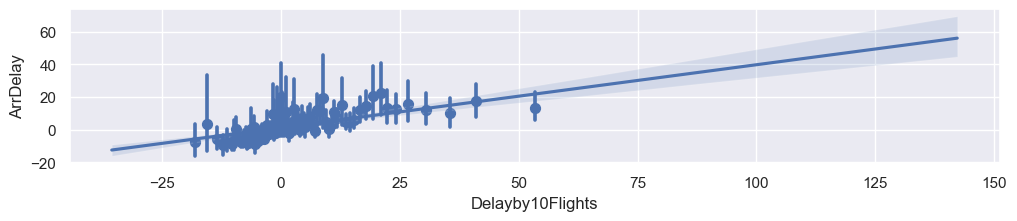

In [71]:
sns.set(rc={'figure.figsize':(12,2)})
vec = df16[ (df16.FlightCount==365) & (df16.Delayby10Flights.notna()==True) ].Delayby10Flights.index
plotData = df16.loc[vec,:].sample(frac=0.1)
ax=sns.regplot(data=plotData, x="Delayby10Flights",y="ArrDelay",
              x_bins=plotData['Delayby10Flights'].quantile(np.arange(0.01,1,0.01)))


In [ ]:
the prediction is not good. 
it looks linear, but the line pass x=50 at y=20. if it is linear we can construct a model from it? I could try.

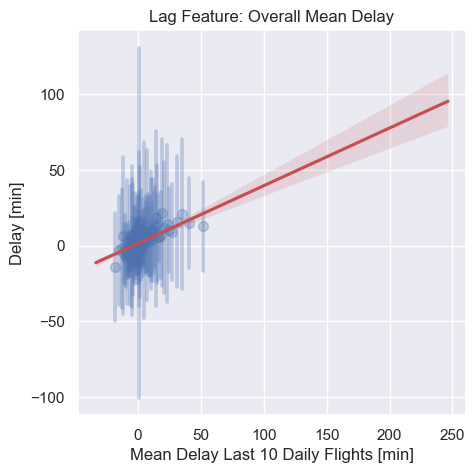

In [74]:
sns.set(rc={'figure.figsize':(5,5)})
plotData = df16.loc[vec,:].sample(frac=0.1)
ax=sns.regplot(data=plotData, x="Delayby10Flights",y="ArrDelay",
    x_bins=plotData['Delayby10Flights'].quantile(np.arange(0.01,1,0.01)), 
    x_ci='sd',
    scatter_kws=dict(alpha=.3), line_kws=dict(color="r")
)
ax.set(xlabel='Mean Delay Last 10 Daily Flights [min]', ylabel='Delay [min]', title='Lag Feature: Overall Mean Delay')
plt.show()

##### Airport Size

There are 304 airports in the dataset.
I divide the airports into three groups:
The large airports with more than 100K flights overall (44 airports).
The medium airports with between 100K and 10K flights overall (96 airports).
The small airports with less than 10K flights overall (164 airports).

In [6]:
aplist = df16.Origin.unique()
#groups = df16.groupby('Origin')['Origin'].count()
groups = df16.groupby('Origin')
airportDict = {}
for group in groups:
    airportDict[group[0]] = [ group[1].Origin.count(),0,0]
groups = df16.groupby('Dest')
for group in groups:
    airportDict[group[0]][1] = group[1].Dest.count()
    airportDict[group[0]][2] = airportDict[group[0]][0]+airportDict[group[0]][1]
airportList1 = list( airportDict.items() )
apsizelist = [ [x[0],x[1][2]] for x in airportList]
apsizelist = sorted( apsizelist, reverse=True, key=lambda x: x[1] )
apsize = pd.DataFrame(apsizelist)

NameError: name 'airportList' is not defined

[Text(0.5, 0, 'Airport Index'), Text(0, 0.5, 'Number of Flights')]

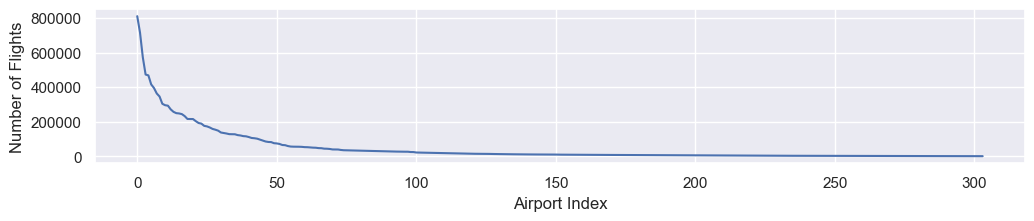

In [134]:
sns.set(rc={'figure.figsize':(12,2)})
sns.lineplot(data=apsize,legend = False ).set(xlabel='Airport Index',ylabel='Number of Flights') #.set(yscale='log')

Number of flights as indicator of airport size, plotted for each of the airports in the dataset.


In [159]:
apsize.rename(columns={0:'ApName',1:'ApSize'},inplace=True)

In [179]:
df16 = df16.merge(apsize,how='left', left_on='Origin', right_on='ApName',copy=False).rename(columns={'ApSize':'OrgSize'})
df16.drop(columns=['ApName'],axis=1, inplace=True)
df16 = df16.merge(apsize,how='left', left_on='Dest', right_on='ApName',copy=False).rename(columns={'ApSize':'DestSize'})
df16.drop(columns=['ApName'],axis=1, inplace=True)
df16['OrgCat'] = pd.cut(x=df16['OrgSize'], bins=[0, 10000, 100000, df16.OrgSize.max()], 
                     labels=['smallOrg', 'mediumOrg', 'largeOrg']) 


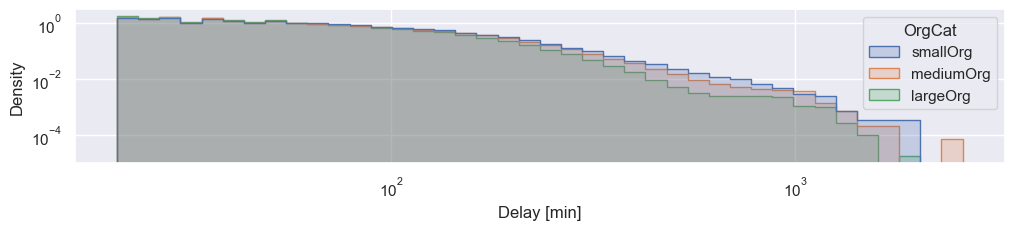

In [412]:
fig, ax = plt.subplots(figsize=(12,2))
sns.histplot(data=df16.sample(frac=1).query('ArrDelay>20'), x="ArrDelay", bins=40, element='step',
             hue="OrgCat", ax=ax, stat='density', common_norm=False, log_scale=True).set(yscale='log',
             xlabel='Delay [min]')#,xlim=[20,2600])
plt.show()


44 airports with more than 100,000 flights

96 airports with more than 10,000 flights but less than 100,000 flights

164 airports with less than 10,000 flights

Initially I calculated size using the first few months of the year (4,6,9), but the category of the airport does not change.
In the current data frame the data is the size over 12M. It'll not change much if it were only the first 4M.


#### Lag Features: an example

So far the added features were simple features and did not contain time lag information. The remaining features make use of the rolling function and contain lag features.

I give here only one example of the type of features I created and checked.
This feature is the average delay over one day in a specific airport that happened exactly a week before the current flight.
The merging is rather complex: I merge the 1-day-average-delay of a week ago onto the flights that leave this airport and whose departure time is approximately a week after the time the data was collected.
The logic of the algorithm is as follows:
1. Sort the whole DataFrame by ArrTimeUTC.
2. Group by 'Dest' - destination airport. The average delay will be specific to this airport.
3. For each group in groupby which corresponds to a specific destination, take the averaged delay of all flights whose planned arrival time is within a window - a day, in this case.
4. merge  this average (named 'DelaybyArrTimeDest7d') to the flights with relevant departure time and whose 'Origin' corresponds to the delay destination. So flights leaving a certain airport have in their row the information about the 1-day average delay of the same day of the week in the previous week.
4.1 Before merging: eliminating duplicates of the combination airport+hour (several flights coming in on the same hour have different average delay)
5. Merge with main df

The code for this calculation is given below:

In [ ]:
#converting to datetime object
df14['DepTimeUTC'] = pd.to_datetime(df14.DepTimeUTC)
df14['ArrTimeUTC'] = pd.to_datetime(df14.ArrTimeUTC)
# adding a column with approximate departure time (minutes are discarded)
# later I will merge the average delay on this. 
df14['DepTimeUTCHr'] = df14['DepTimeUTC'].dt.to_period('H')

lags=['7d']   # days
window = '1d' # days
sort_df_by = 'ArrTimeUTC' #sorting the dataframe by arrival time. needed for rolling function
groupby_col = 'Dest'      #group the flights by Dest and calculate mean Delay at each destination airport
col_for_time_window = 'ArrTimeUTC' # I calculate the time window on ArrTimeUTC
merge_on_col = 'DepTimeUTC' #I merge ArrivalTimeHr on DepTimeHr

#1. sorting
df14.sort_values( by=sort_df_by, inplace=True, ignore_index=True ) # this is needed because depTime is in AUC time

#2. groupby
groups = df14.groupby(groupby_col) 
for lag in lags:
    mean_delay_name = 'DelaybyArrTimeDest' + lag # new column
    aiddf = pd.DataFrame()
    for group in groups:
        #Dest = group[0] #if I wanted to see the airport of the group
                          #0 is the Dest name and 1 is the data  
        #3. rolling function: calculate averaged delay over past day
        singleDest = group[1].rolling( window, on=col_for_time_window, closed='left' )['ArrDelay'].mean()
        aiddf = pd.concat([aiddf,singleDest])
    #4. merging with principal DataFrame
    aiddf.rename(columns={0:mean_delay_name},inplace=True)
    aiddf = aiddf.merge( df14.loc[:,col_for_time_window], copy=False, left_index=True, right_index=True )
    aiddf = aiddf.merge( df14.loc[:,groupby_col]        , copy=False, left_index=True, right_index=True )
    #so far aiddf contains Dest and ArrTimeUTC
    # shift aiddf/merge by lag (can not use shift because index is not datetime)
    aiddf.loc[:,'InsertTime'+lag] = aiddf.loc[:,col_for_time_window].add(pd.to_timedelta(lag)).dt.to_period('H')
    
    '''
    perhaps I should change the line above to
    aiddf.loc[:,'InsertTime'+lag] = aiddf.loc[:,col_for_time_window] + pd.to_timedelta(lag)
    aiddf.loc[:,'InsertTime'+lag].dt.to_period('H')
    '''
    
    df14[merge_on_col + 'Hr']         =  df14.loc[:,merge_on_col].dt.to_period('H')

    #4.1 eliminating duplicates of the combination airport+hour (several flights coming in on the same hour have different average delay)
    # rollingDelay1 index is ArrTimeHr and Dest, the column is DelaybyArrTimeDest
    rollingDelay1 = aiddf.groupby(['InsertTime'+lag,groupby_col]).max()
    rollingDelay1.drop(col_for_time_window, axis=1, inplace=True)

    #5. mergeing with main df
    df14 = df14.merge(rollingDelay1, how='left', sort=False,\
                  left_on=[merge_on_col+'Hr','Origin'], right_on = ['InsertTime'+lag,'Dest'])
df14.drop(merge_on_col+'Hr', axis=1, inplace=True)


In [ ]:
code example: should not run

# changing column dtype and calculating PlannedElapsedTime in min
df14['DepTime'] = pd.to_datetime(df14.DepTime)
df14['ArrTime'] = pd.to_datetime(df14.ArrTime)
#df14['DepTime_in_ArrTZ'] = pd.to_datetime(df14.DepTime_in_ArrTZ)
df14['DepTimeUTC'] = pd.to_datetime(df14.loc[:,'DepTime'], yearfirst=True, utc=True, format='%Y-%m-%d %H:%M:%S%z')
#                                                  everything is converted to utc time
#this gives a datetime object instead of a string

df14['ArrTimeUTC'] = pd.to_datetime( df14.loc[:,'ArrTime'], yearfirst=True, utc=True, format='%Y-%m-%d %H:%M:%S%z')
#this gives a datetime object in utc time already

## adding Planned Elapsed Time as a column in df14, the same as was done to the small df above
df14['PlannedElapsedTime'] = df14.ArrTimeUTC - df14.DepTimeUTC #timedelta obj
## converting PlannedElapsedTime to minutes
df14['PlannedElapsedTime'] = df14.PlannedElapsedTime/ pd.Timedelta(minutes=1)
df14.loc[:,'ActualArrTime'] = df14.loc[:,'ArrTime'].add(pd.to_timedelta(df14.ArrDelay,'min'))
# to_timedelta is the crucial command here


In [5]:
cols14 = ['Month','DayofMonth','DayofWeek', 'Origin','Dest','Distance','ArrDelay','DepTimeUTC','ArrTimeUTC',
          'DepTZH','ArrTZH','DepHrOnly','ArrHrOnly',
          'DelaybyActualArrTimeDest1h', 'DelaybyActualArrTimeDest15min', 'Mean1h', 'Mean3h']

dtype_dict = {'Year' : 'uint16',  
             'Month': 'uint8', \
             'DayofMonth' : 'uint8', \
             'DayofWeek' : 'uint8', \
             'CRSDepTime' : 'uint16', \
             'CRSArrTime' : 'uint16', \
             'FlightTime' : 'uint16', \
             'ActualElapsedTime' : 'uint16', \
             'Distance' : 'uint16', \
             'ArrDelay' : 'int16'}

df14 = pd.read_csv('..\\AirportData2\\df14_csv', usecols = cols14, dtype = dtype_dict ) 


In [8]:
len(df14.sample(frac=0.1))

405377

In [19]:
df14.sample(frac=0.1)['Mean1h'].quantile(np.arange(0.1,1,0.1))

0.1    -0.017013
0.2     2.555286
0.3     4.970401
0.4     7.375099
0.5     9.861065
0.6    12.740952
0.7    16.281558
0.8    21.366326
0.9    29.424510
Name: Mean1h, dtype: float64

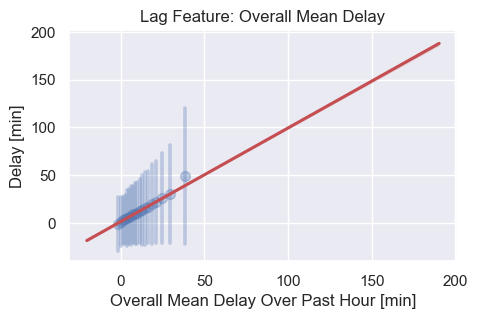

In [24]:
sns.set(rc={'figure.figsize':(5,3)})
ax=sns.regplot(
    x='Mean1h',y='ArrDelay',data=df14.sample(frac=0.1),
    x_bins=df14.sample(frac=0.1)['Mean1h'].quantile(np.arange(0.05,1,0.05)), 
    x_ci='sd',
    scatter_kws=dict(alpha=.3), line_kws=dict(color="r")
)
ax.set(xlabel='Overall Mean Delay Over Past Hour [min]', ylabel='Delay [min]', title='Lag Feature: Overall Mean Delay')
plt.show()

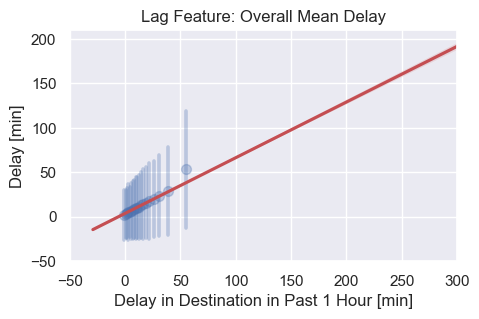

In [28]:
sns.set(rc={'figure.figsize':(5,3)})
ax=sns.regplot(
    x='DelaybyActualArrTimeDest1h',y='ArrDelay',data=df14.sample(frac=0.1),
    x_bins=df14.sample(frac=0.1)['DelaybyActualArrTimeDest1h'].quantile(np.arange(0.05,1,0.05)), 
    x_ci='sd',
    scatter_kws=dict(alpha=.3), line_kws=dict(color="r")
)
ax.set(xlabel='Delay in Destination in Past 1 Hour [min]', ylabel='Delay [min]', title='Lag Feature: Overall Mean Delay')
plt.xlim([-50,300])
plt.ylim([-50,210])
plt.show()

### ActualElapsedTime: Avoid Data Leakage
ActualElapsedTime seems, on the surface, to contain delay infromation. Because the exact meaning of ActualElapsedTime is not given, I tried to understand it by guessing and checking a few possibilities.


#### Is ActualElapsedTime PlannedElapsedTime + Delay? No


    1. what is the phase transition in the middle? I will plot in hours and find out
    it seems that flights shorter than ~7 hours has larger standard deviation (more noise) than longer than 7 hours. Does it mean we need different models for these areas?
    hypthesis: there are many more flights under 7 hours (between coasts of USA). larger than 7: only to honelulu and alaska and such - much less flights.
    
    2. do the vertical lines represent repeated flights with different actual elapsed time?
    3. check outliers above the main graph.
    4. do the bottom dots represent 1:1 ratio? x=y? no. ActualElapsedTime is sometimes smaller than PlannedElapsedTime (the opposite of delay)

#### Check ActualElapsedTime Various Interpretations
I expected the velocity to have either constant or slightly rising linear relationship with Distance.
Here I also ran a little check to see that flights with very low velocities are also very short flights.

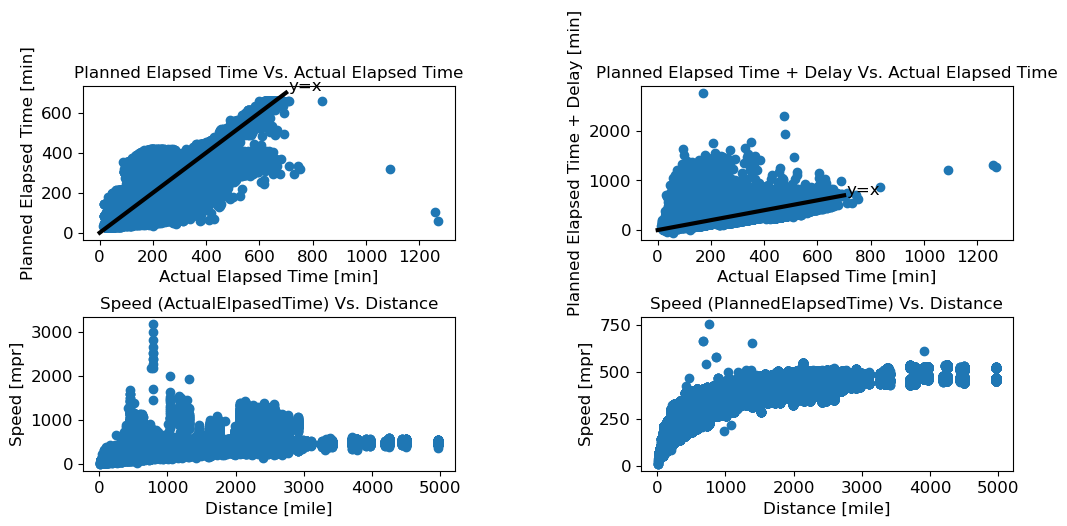

In [38]:
from PlotActualElapsedTime1 import get_ActualElapsedTime_plot1

speedA = df14.Distance / (df14.ActualElapsedTime/60.0) #speed calculated with ActualElapsedTime
speedP = df14.Distance / (df14.PlannedElapsedTime/60.0) # speed calculated with PlannedElapsedTime

x_axis_var = [df14.ActualElapsedTime,
              df14.ActualElapsedTime,
              df14.Distance,
              df14.Distance]
y_axis_var = [df14.PlannedElapsedTime,
              df14.PlannedElapsedTime + df14.ArrDelay,
              speedA,
              speedP]
titles=['Planned Elapsed Time Vs. Actual Elapsed Time',
        'Planned Elapsed Time + Delay Vs. Actual Elapsed Time',
        'Speed (ActualElpasedTime) Vs. Distance',
        'Speed (PlannedElapsedTime) Vs. Distance'    ]
xlabels = ['Actual Elapsed Time [min]',
           'Actual Elapsed Time [min]',
           'Distance [mile]',
           'Distance [mile]'      ]
ylabels = ['Planned Elapsed Time [min]',
           'Planned Elapsed Time + Delay [min]', 
           'Speed [mpr]',
           'Speed [mpr]']

get_ActualElapsedTime_plot1(x_axis_var,y_axis_var,titles,xlabels,ylabels)

#### conclusions: ActualElapsedTime is Unknown
ActualElapsedTime is not PlannedElapsedTime + Delay. The relationship in that plot is linear but with a very large margin.
ActualElapsedTime is not time in the air.
I do not know what it is so I discard it from the data. I expected the velocity to have either constant or slightly rising 
linear relationship with Distance.

In [16]:
df14.drop(labels=['ActualElapsedTime'],axis=1,inplace=True)
df.drop(labels=['ActualElapsedTime'],axis=1,inplace=True)

### Delay Histogram
##### Simple Delay Histogram

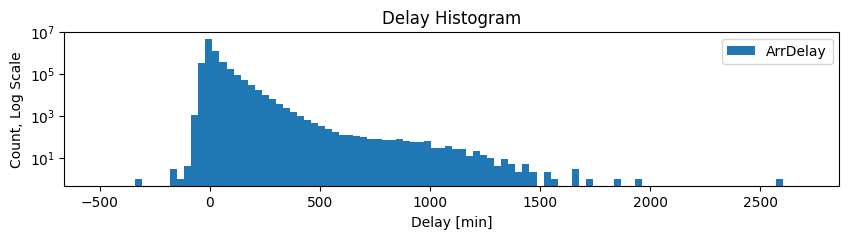

In [5]:
df16[df16['ArrDelay']!=0].plot.hist(column=['ArrDelay'], bins=100, figsize=(10,2),logy=True,range=[-500,2700])
plt.ylabel('Count, Log Scale')
plt.xlabel('Delay [min]')
plt.title('Delay Histogram')
plt.show()



Delays shorter than 600 minutes (10 hours) are exponentially distributed - the probability for a delay decreases
exponentially with the lengh of the delay. Delays longer than 600 minutes have a fat-tailed distribution, with a probability 
much larger than that expected by an exponential distribution.
indeed, between 600 minutes and 1000 minutes the probability of a delay is almost constant.

##### Delay/Planned Flight Time Histogram - a Statistical Inference Model
Because it uses the Delay I can not use it in inference, but if I calculate this on the first 6 months perhaps
I could use it to predict the 7th month.

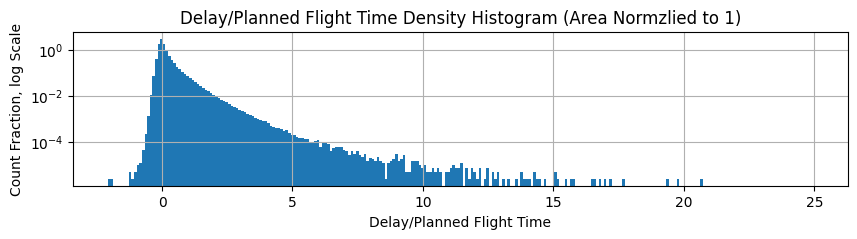

In [165]:
## adding Planned Elapsed Time as a column in df14, the same as was done to the small df above
df14['PlannedElapsedTime'] = df14.ArrTimeUTC - df14.DepTimeUTC #timedelta obj
## converting PlannedElapsedTime to minutes
df14['PlannedElapsedTime'] = df14.PlannedElapsedTime/ pd.Timedelta(minutes=1)

delay_frac = pd.Series( df14.ArrDelay/df14.PlannedElapsedTime.astype(float),index = df14.index)
plt.figure(figsize=(10,2))
bins = plt.hist(delay_frac, label="delay frac", density=True,
                bins=np.arange(delay_frac.min(),delay_frac.max(),0.1),log=True)
plt.title('Delay/Planned Flight Time Density Histogram (Area Normzlied to 1)')
plt.xlabel('Delay/Planned Flight Time')
plt.ylabel('Count Fraction, log Scale')
plt.grid()

many many delays are much longer than the flight length.

how come fraction of count is larger than one? that's because the fraction count/total count is further divided by bin length

##### Phase Transition at roughly 400 min
interesing: longer flights (longer than 7 hours) have up to 4 hours delays typically, 
   while shorter flights may be delayed by 10 hours and more
    
is it because there are much more shorter flights? 
yes, 0.2% of flights are larger than 400 minutes


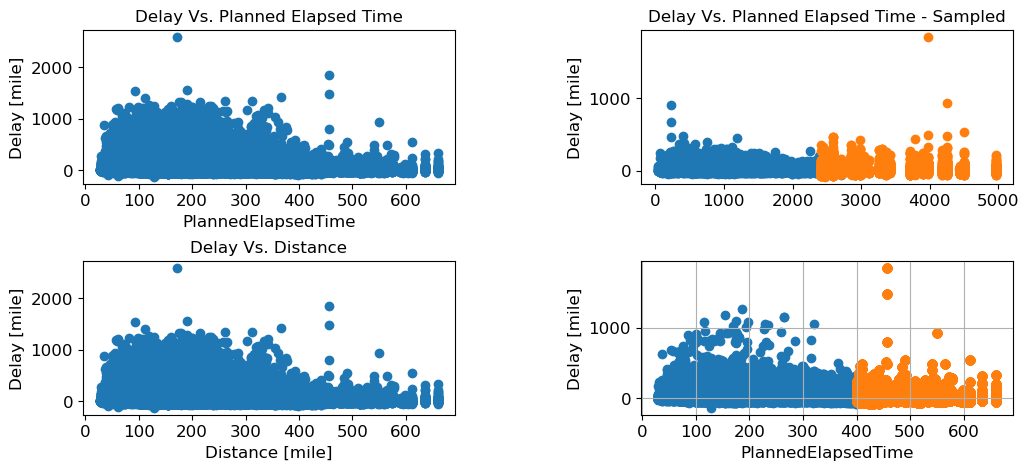

In [17]:
from Plot_Delay_phase1 import get_Delay_phase_plot1

regime_division = [0,400,2600]
regime_column = 'PlannedElapsedTime'
n_samples = [10000,500000]
x_axis_var = ['PlannedElapsedTime',
              'Distance',
              'PlannedElapsedTime',
              'PlannedElapsedTime']
y_axis_var = ['ArrDelay',
              'ArrDelay',
              'ArrDelay',
              'ArrDelay']
titles=['Delay Vs. Planned Elapsed Time',
        'Delay Vs. Planned Elapsed Time - Sampled',
        '',
        '']
xlabels = ['PlannedElapsedTime',
          '',
           'Distance [mile]',
          'PlannedElapsedTime']
ylabels = ['Delay [mile]',
           'Delay [mile]',
           'Delay [mile]',
           'Delay [mile]']
get_Delay_phase_plot1(df14,regime_division, regime_column, n_samples,x_axis_var,y_axis_var,titles,xlabels,ylabels)



In the above 2 and 4 pannel I sample 10,000 and 50,000 samples from under 400 min and above 400 min Planned Elapsed Time 
groups.
it looks like the larger amplitude of delay is a result of the number of flights in each group rather then somethin 
inherent to short and long flights.

In [19]:
print('Number of flights longer than 400 minutes: ',len( df14.PlannedElapsedTime[df14.PlannedElapsedTime>=400] ) )
print('Number of flights shorter than 400 minutes: ',len( df14.PlannedElapsedTime[df14.PlannedElapsedTime<400] ) )
print('Ratio:',
      np.round( len( df14.PlannedElapsedTime[df14.PlannedElapsedTime>=400])/len(df14.PlannedElapsedTime
                                                                                [df14.PlannedElapsedTime<400]) ,4) 
         ) 

Number of flights longer than 400 minutes:  11129
Number of flights shorter than 400 minutes:  4042637
Ratio: 0.0028


Would restricting the inference to flights shorter than 400 minutes improve model results?
flights longer than 400 minutes?

### A Small Model - Simple Features

#### Model 1 Parameter Search

In [ ]:
from Model1RandomForest import RandomForestPipeline
import time

start = time.time()
cols = ['UniqueCarrier', 'Origin', 'Dest','Month', 'DayofMonth', 'DayofWeek', 'FlightNum', 'Distance', 
        'PlannedElapsedTime','ArrDelay']
target_col = 'ArrDelay'
sample_start = 0
sample_end = sample_start + 100000 #len(df14)
res_ne,res_ns,res_MAE_train,res_MAE_test,res_mean_MAE_test,res_mean_MAE_train = [],[],[],[],[],[]
for ne in [5, 10,20,50,80]:
    for ns in [4, 10, 20, 50, 100]:
            train_size, test_size, MAE_train, MAE_test,_, _, _, _ = \
            RandomForestPipeline(df14[cols],target_col,sample_start,sample_end,ne,ns)
            res_ne.append(ne)
            res_ns.append(ns)
            res_MAE_train.append(MAE_train)
            res_MAE_test.append(MAE_test)
            res_mean_MAE_test.append(round( np.mean(MAE_test)) )
            res_mean_MAE_train.append(round( np.mean(MAE_train)) )
end=time.time()
print('time elapsed: ',np.round( (end-start)/60.0,4),'[min]')
resData = pd.DataFrame({'n_split':ns,
                        'n_estimators':ne,
                        'mean_MAE_test':res_mean_MAE_test,
                        'mean_MAE_train':res_mean_MAE_train})
resData.plot.scatter(x='n_split',
                     y='n_estimators',
                     c='mean_MAE_test',
                     colormap='viridis',
                     title='Hyperparameter Search for RandomForestRegressor',
                     s=80)

In [7]:
resData = pd.DataFrame({'n_split':res_ns,
                        'n_estimators':res_ne,
                        'mean_MAE_test':res_mean_MAE_test,
                        'mean_MAE_train':res_mean_MAE_train})

<AxesSubplot:xlabel='n_split', ylabel='n_estimators'>

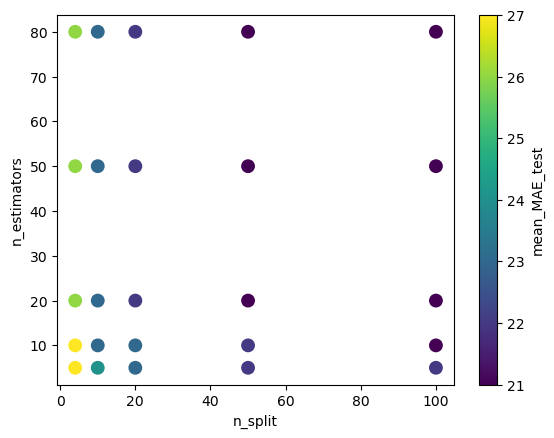

In [8]:
resData.plot.scatter(x='n_split',y='n_estimators',c='mean_MAE_test',colormap='viridis',s=80)

#### Model 1 Learning Curve - mean absolute error as function of training set size

In [25]:
from Model1RandomForest import RandomForestPipeline
import time

start = time.time()
cols = ['UniqueCarrier', 'Origin', 'Dest','Month', 'DayofMonth', 'DayofWeek', 'FlightNum', 'Distance', 
        'PlannedElapsedTime','ArrDelay']
target_col = 'ArrDelay'
sample_start = 0
sample_end = sample_start + len(df14)
ne=20 #n_estimators
ns=50 # n_splits
res_ne,res_ns,res_MAE_train,res_MAE_test,res_mean_MAE_test,res_mean_MAE_train = [],[],[],[],[],[]
preds_train_list, preds_test_list, y_train_list, y_test_list = [],[],[],[]
train_size, test_size, MAE_train, MAE_test, preds_train_list, preds_test_list, y_train_list, y_test_list = \
RandomForestPipeline(df14[cols],target_col,sample_start,sample_end,ne,ns)
res_ne.append(ne)
res_ns.append(ns)
res_MAE_train.append(MAE_train)
res_MAE_test.append(MAE_test)
res_mean_MAE_test.append(round( np.mean(MAE_test)) )
res_mean_MAE_train.append(round( np.mean(MAE_train)) )
end=time.time()
print('time elapsed: ',np.round( (end-start)/60.0,4),'[min]')


last split, X train length: 3040325, X test length: 1013437
time elapsed:  9.0116 [min]
time elapsed:  9.0977 [min]


<function matplotlib.pyplot.show(close=None, block=None)>

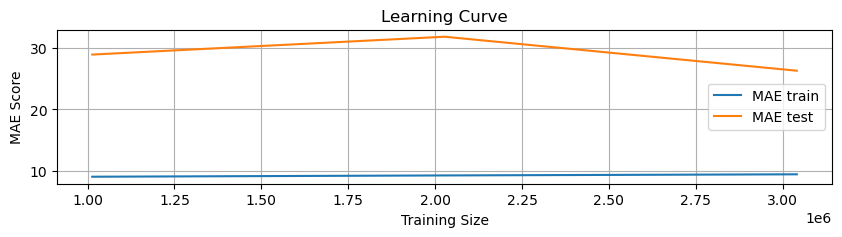

In [26]:
plt.figure(figsize=(10,2))
plt.plot(train_size, MAE_train,label='MAE train')
plt.plot(train_size, MAE_test,label='MAE test')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('MAE Score [min]')
plt.legend()
plt.grid()
plt.show

Mean squared error
|predictedDelay-trueDelay| is given in [min]
and is very low _on average_ for the training set, but larger for the test set.

This indicates Overfitting (although random forests are not prone to Overfitting).


illustration of individual predictions in training set:

<function matplotlib.pyplot.show(close=None, block=None)>

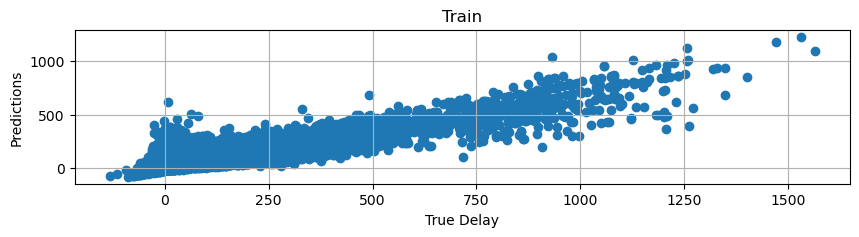

In [27]:
plt.figure(figsize=(10,2))
plt.scatter(y_train_list[-1],preds_train_list[-1])
plt.title('Train')
plt.xlabel('True Delay')
plt.ylabel('Predictions')
plt.grid()
plt.show()

illustration of individual predicitons in test set

<function matplotlib.pyplot.show(close=None, block=None)>

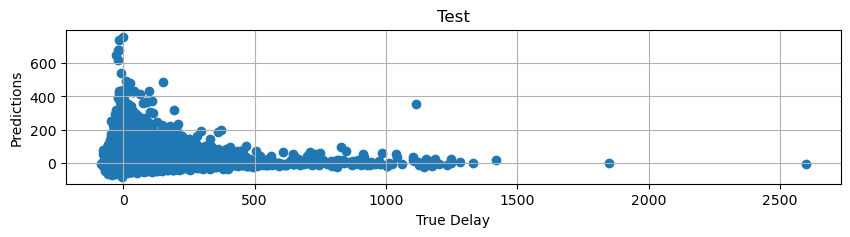

In [28]:
plt.figure(figsize=(10,2))
plt.scatter(y_test_list[-1],preds_test_list[-1])
plt.title('Test')
plt.xlabel('True Delay')
plt.ylabel('Predictions')
plt.grid()
plt.show()

Learning curve: the MAE of the test set is much larger than the MAE of the training set.
This indicates overfitting - learning well to predict results within the training set but not a good generalization to
other data.
When the predicted values are plotted against true values, it can be seen that there is not a linear relationship between 
predictions and true values. The model performs much worse for the test set than the training set.

Usually we correct overfitting by reducing the complexity of the model: reducing the number of features (could be preceded 
by feature analysis or PCA) or, in the random forest example, the maximal depth of the trees. In linear regression models
we could increase regularization. Increasing the dataset size, if 
possible, is also beneficial. 
    
    
However, random forest models arrive at the results after performing an average over many trees. Overfitting is not a problem
usually.
Also, repeated attempts to reduce comlexity here do not result in any change to the learning curve.

Therefore I conclude that The results are due to the fact that the test dataset, which always comes temperaly after the 
training set, as is always the case in time series, is inherently different. In other words, there is a trend I have not 
detected so far.

Future analysis can concentrate on understanding this trend.

* PCA results are much worse - MAE_train is 10 but MAE_test is 40 and 60 does not help overfitting


### CatBoost Model

In [339]:
from Model3CatBoost import CatBoostPipeline
import time

df16['DepTimeUTC'] = pd.to_datetime(df16.DepTimeUTC)
df16['ArrTimeUTC'] = pd.to_datetime(df16.ArrTimeUTC)
## adding Planned Elapsed Time as a column in df14, the same as was done to the small df above
df16['PlannedElapsedTime'] = df16.ArrTimeUTC - df16.DepTimeUTC #timedelta obj
## converting PlannedElapsedTime to minutes
df16['PlannedElapsedTime'] = df16.PlannedElapsedTime/ pd.Timedelta(minutes=1)


start = time.time()
cols = ['UniqueCarrier', 'Origin', 'Dest','Month', 'DayofMonth', 'DayofWeek', 'FlightNum', 'Distance', 
        'PlannedElapsedTime','ArrDelay']
target_col = 'ArrDelay'
sample_start = 0
sample_end = sample_start + 2000000 #len(df16)
res_ni,res_ns,res_MAE_train,res_MAE_test,res_mean_MAE_test,res_mean_MAE_train = [],[],[],[],[],[]
res_ix_train, res_ix_test = [],[]
for ni in [300]:
    for ns in [6]:
            MAE_train, MAE_test,preds_train_list, preds_test_list, y_train_list, y_test_list,ix_train, ix_test, model = \
            CatBoostPipeline(df16.loc[:,cols],target_col,sample_start,sample_end,n_splits=ns,numIterations=ni,learning_rate=0.1,seed=123)
            res_ni.append(ni)
            res_ns.append(ns)
            res_MAE_train.append(MAE_train)
            res_MAE_test.append(MAE_test)
            res_mean_MAE_test.append(round( np.mean(MAE_test)) )
            res_mean_MAE_train.append(round( np.mean(MAE_train)) )
            res_ix_train.append( ix_train)
            res_ix_test.append(ix_test)
end=time.time()
print('time elapsed: ',np.round( (end-start)/60.0,4),'[min]')


last split, X train length: 1714287, X test length: 285714
time elapsed:  3.2312 [min]
time elapsed:  3.2482 [min]


In [351]:
dfPreds = pd.concat([  pd.DataFrame( np.round( preds_train_list[-1] ),index=res_ix_train[-1], columns=['Preds'] ),
                       pd.DataFrame( np.round( preds_test_list[-1] ), index=res_ix_test[-1], columns=['Preds'] ) 
                     ] )
df16 = df16.merge(dfPreds,how='left',left_index=True, right_index=True)

# Creating a new column named 'Set' to indicate if the Predictions came from Train or Test
df16.loc[res_ix_train[-1],'Set'] = 'Train'
df16.loc[res_ix_test[-1],'Set'] = 'Test'


<function matplotlib.pyplot.show(close=None, block=None)>

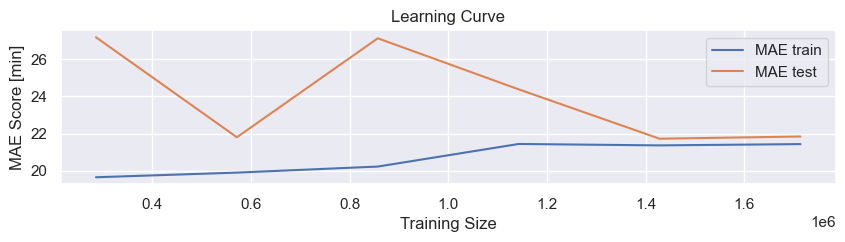

In [218]:
plt.figure(figsize=(10,2))
plt.plot(train_size, MAE_train,label='MAE train')
plt.plot(train_size, MAE_test,label='MAE test')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('MAE Score [min]')
plt.legend()
#plt.grid()
plt.show

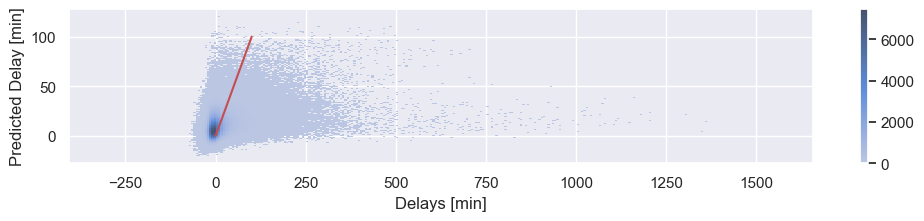

In [233]:
sns.set(rc={'figure.figsize':(12,2)})
ax=sns.histplot(x=y_train_list[-1],y=preds_train_list[-1],bins=300, cbar=True)
ax.set(xlabel='Delays [min]',ylabel='Predicted Delay [min]',title='Train Predictions and Data')
ax.plot([0,100], [0,100], 'r-')
plt.show()


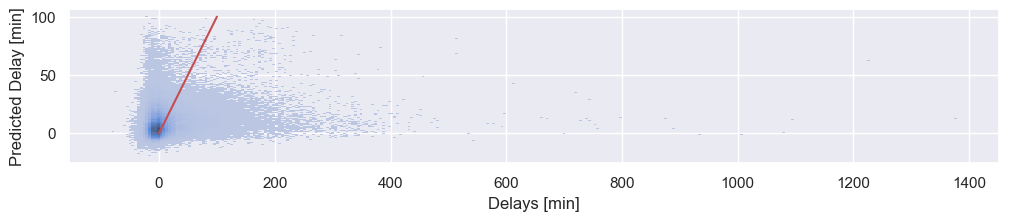

In [230]:
sns.set(rc={'figure.figsize':(12,2)})
ax=sns.histplot(x=y_test_list[-1],y=preds_test_list[-1],bins=300)
ax.set(xlabel='Delays [min]',ylabel='Predicted Delay [min]',title='Test Predictions and Data')
ax.plot([0,100], [0,100], 'r-')
plt.show()


[Text(0.5, 25.0, 'Delays [min]'),
 Text(25.078125, 0.5, 'Cound Log Scale'),
 Text(0.5, 1.0, 'Histogram of Absolute Value of Error (Residuels)')]

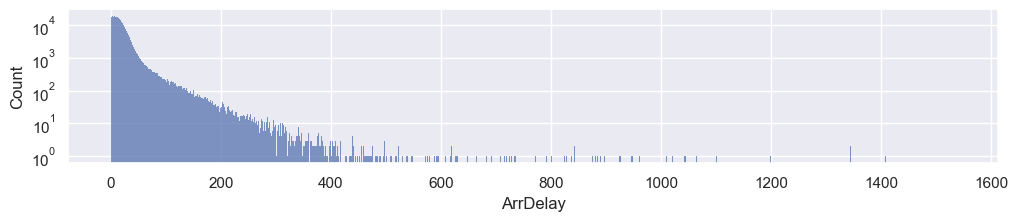

In [247]:
sns.histplot(x= abs( y_train_list[-1]-preds_train_list[-1]) ).set(yscale='log') #xlim=[-1,2000]
ax.set(xlabel='Delays [min]',ylabel='Cound Log Scale',title='Histogram of Absolute Value of Error (Residuels)')


In [341]:
pd.Series(np.abs( y_train_list[-1]-preds_train_list[-1] ) ).describe()

count    1.714287e+06
mean     2.142779e+01
std      3.028269e+01
min      2.154057e-05
25%      7.114861e+00
50%      1.455133e+01
75%      2.498565e+01
max      1.536749e+03
Name: ArrDelay, dtype: float64

In [ ]:
box plot for binned delay: distribution of prediction
unbalanced data set
new model catboost classifier


In [249]:
df16.columns

Index(['Month', 'DayofMonth', 'DayofWeek', 'UniqueCarrier', 'FlightNum',
       'Origin', 'Dest', 'Distance', 'ArrDelay', 'DepTime', 'ArrTime',
       'DepTimeUTC', 'ArrTimeUTC', 'DepTimeHrOnly', 'ArrTimeHrOnly',
       'FlightCount', 'FlightMeanDelay', 'Delayby10Flights', 'OrgSize',
       'DestSize', 'OrgCat', 'PlannedElapsedTime'],
      dtype='object')

### Binning the Delays

In [332]:
binvec = list(range(1,25) )
binvec = [-400,1]+[60*x for x in binvec] +[72*60]
print(binvec)

[-400, 1, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840, 900, 960, 1020, 1080, 1140, 1200, 1260, 1320, 1380, 1440, 4320]


In [333]:
df16['DelayCat'] = pd.cut(x=df16['ArrDelay'], bins=binvec, 
                     labels=False) 


In [268]:
df16.loc[0:10,['ArrDelay','DelayCat'] ]

,ArrDelay,DelayCat
0,-4,0.0
1,25,1.0
2,36,1.0
3,-3,0.0
4,42,1.0
5,-13,0.0
6,5,1.0
7,10,1.0
8,-9,0.0
9,41,1.0


In [ ]:
# create a new column with predictions another column claiming train or test


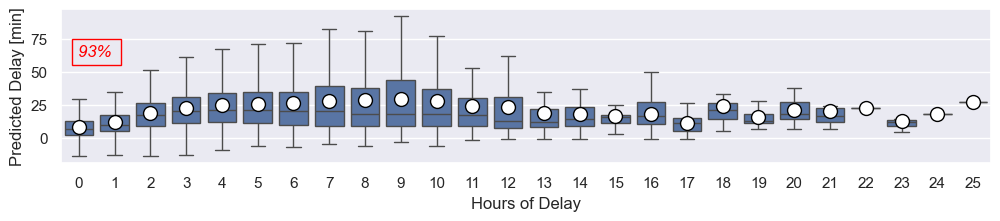

In [382]:

sns.set(rc={'figure.figsize':(12,2)})
ax=sns.boxplot(x="DelayCat", y="Preds", data=df16, 
               showmeans=True,
               meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"},
               showfliers=False)
ax.set(xlabel='Hours of Delay',ylabel='Predicted Delay [min]')
#ax1.set(xlabel='Hours of Delay',ylabel='Predicted Delay [min]',xticks=['1','2','3','4','5','6','7'],
#        xticklabels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
#f.tight_layout()
ax.text(0.5, 65, "93% ",
       fontsize = 12,          # Size
       fontstyle = "oblique",  # Style
       color = "red",          # Color
       ha = "center", # Horizontal alignment
       va = "center", # Vertical alignment 
       bbox=dict(facecolor='none', edgecolor='red'))

plt.show()

In [372]:
DelayCatVolume = df16.groupby('DelayCat').size()
print(DelayCatVolume)

DelayCat
0     3998412
1     2750596
2      353974
3      109294
4       37684
5       13996
6        5630
7        2431
8        1117
9         571
10        323
11        220
12        197
13        148
14        136
15        137
16        112
17         86
18         57
19         58
20         28
21         35
22         12
23         13
24          9
25         12
dtype: int64
